In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q --upgrade python-terrier
!pip install --upgrade -q git+https://github.com/Georgetown-IR-Lab/OpenNIR
!pip install --upgrade -q git+https://github.com/terrierteam/pyterrier_t5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.4/347.4 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.3 MB/s eta 0:00:00
  Preparing metadata (setup.

In [ ]:
import pyterrier as pt

if not pt.started():
    pt.init(tqdm='notebook', boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

import onir_pt

terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done
terrier-prf -SNAPSHOT jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [ ]:
dataset_path = '/content/drive/My Drive/IR_project/wikIR59k/'

## Import dataset

In [ ]:
import onir_pt
import pandas as pd

In [ ]:
#Train
dataset_train = pt.get_dataset('irds:wikir/en59k/training')

#Validation
dataset_validation = pt.get_dataset('irds:wikir/en59k/validation')

#Test
dataset_test = pt.get_dataset('irds:wikir/en59k/test')

In [ ]:
#Train
queries_train = dataset_train.get_topics(variant = "text")

#Validation
queries_validation =  dataset_validation.get_topics(variant = "text")

#Test
queries_test = dataset_test.get_topics(variant = "text")

[INFO] If you have a local copy of https://zenodo.org/record/3557342/files/wikIR59k.zip, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/c9f7e646e022eea84e6f00e3870ca79b
[INFO] [starting] https://zenodo.org/record/3557342/files/wikIR59k.zip
[INFO] [finished] https://zenodo.org/record/3557342/files/wikIR59k.zip: [11.66s] [1.15GB] [99.0MB/s]


In [ ]:
#Train
qrels_train = dataset_train.get_qrels()

#Validation
qrels_validation =  dataset_validation.get_qrels()

#Test
qrels_test = dataset_test.get_qrels()

In [ ]:
documents_iter = (doc for doc in dataset_train.get_corpus_iter() if doc['text'] is not None)
doc_list = [{'docno': doc['docno'], 'text': doc['text']} for doc in documents_iter]
documents = pd.DataFrame(doc_list)

wikir/en59k/training documents:   0%|          | 0/2454785 s<?, ?it/s]

## Exploration analisys

## Creating index

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def counter_feature(dataframe, column_name):

  feature_list = []
  punctuation = set(string.punctuation)

  for index, row in dataframe.iterrows():
    if column_name in row and pd.notnull(row[column_name]):
      character_counter = len(row[column_name])
      punctuation_counter = sum(1 for char in row[column_name] if char in punctuation)
      word_counter = len(row[column_name].split())
      sentence_counter = len(sent_tokenize(row[column_name]))
    else:
      character_counter = 0
      punctuation_counter = 0
      word_counter = 0
      sentence_counter = 0

    feature_list.append([character_counter, punctuation_counter, word_counter, sentence_counter])

  df_feature = pd.DataFrame(feature_list, columns=['character_count', 'punctuation_count', 'word_count', 'sentence_count'])

  return df_feature

In [ ]:
def show_boxplots(df_feature):
    sns.set(style="whitegrid")

    features = ['character_count', 'punctuation_count', 'word_count', 'sentence_count']

    fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 5))

    for ax, feature in zip(axes, features):
        sns.boxplot(y=df_feature[feature], ax=ax)
        ax.set_title(f'Boxplot of {feature}')
        ax.set_ylabel('Counts')
        ax.set_xlabel(feature)

    plt.tight_layout()
    plt.show()

### Documents

In [ ]:
documents.head(10)

,docno,text
0,0,these institutions are often described as stat...
1,1,parents usually notice signs during the first ...
2,2,a planet like earth it is dimensionless and me...
3,3,it is similar to the ancient greek letter alph...
4,4,it is bordered by tennessee to the north georg...
5,5,he was the son of the nereid thetis and peleus...
6,6,lincoln led the nation through the american ci...
7,7,he was the founder of the lyceum and the perip...
8,8,it was inspired by the time that gershwin had ...
9,9,given annually by the academy of motion pictur...


In [ ]:
doc_df_feature = counter_feature(documents, 'text')

In [ ]:
doc_df_feature.head(10)

,character_count,punctuation_count,word_count,sentence_count
0,1340,0,200,1
1,1360,0,200,1
2,1201,0,200,1
3,1118,0,200,1
4,1141,0,200,1
5,1073,0,200,1
6,1202,0,200,1
7,1212,0,200,1
8,1154,0,200,1
9,1201,0,200,1


In [ ]:
doc_df_feature.describe()

,character_count,punctuation_count,word_count,sentence_count
count,2.454785e+06,2454785.0,2.454785e+06,2454785.0
mean,1.144779e+03,0.0,1.977055e+02,1.0
std,8.889635e+01,0.0,9.896216e+00,0.0
min,1.200000e+01,0.0,2.000000e+00,1.0
25%,1.103000e+03,0.0,2.000000e+02,1.0
50%,1.148000e+03,0.0,2.000000e+02,1.0
75%,1.194000e+03,0.0,2.000000e+02,1.0
max,5.084000e+03,0.0,2.000000e+02,1.0


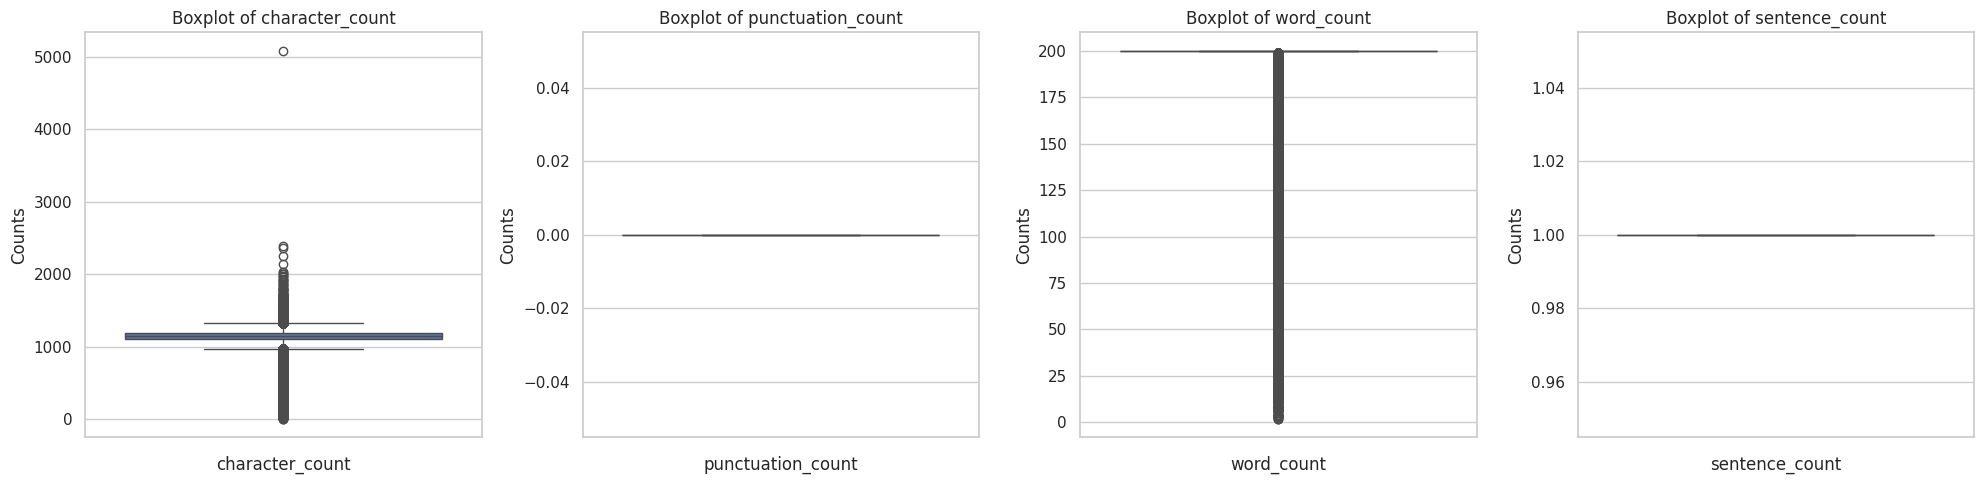

In [ ]:
show_boxplots(doc_df_feature)

### Train queries

In [ ]:
queries_train.head(10)

,qid,query
0,453502,ruggero deodato
1,209890,civil aeronautics board
2,588605,bayburt
3,164190,yangpu district
4,162304,kenner products
5,21505,downing street
6,1054300,ranvir shorey
7,1585751,twenty fifth dynasty of egypt
8,247827,boeing x 37
9,36255,karakum desert


In [ ]:
train_df_features = counter_feature(queries_train, 'query')

In [ ]:
train_df_features.head(10)

,character_count,punctuation_count,word_count,sentence_count
0,15,0,2,1
1,23,0,3,1
2,7,0,1,1
3,15,0,2,1
4,15,0,2,1
5,14,0,2,1
6,13,0,2,1
7,29,0,5,1
8,11,0,3,1
9,14,0,2,1


In [ ]:
train_df_features.describe()

,character_count,punctuation_count,word_count,sentence_count
count,57251.000000,57251.0,57251.000000,57251.000000
mean,15.933224,0.0,2.350911,0.999895
std,8.457117,0.0,1.241187,0.010237
min,0.000000,0.0,0.000000,0.000000
25%,10.000000,0.0,2.000000,1.000000
50%,14.000000,0.0,2.000000,1.000000
75%,19.000000,0.0,3.000000,1.000000
max,92.000000,0.0,12.000000,1.000000


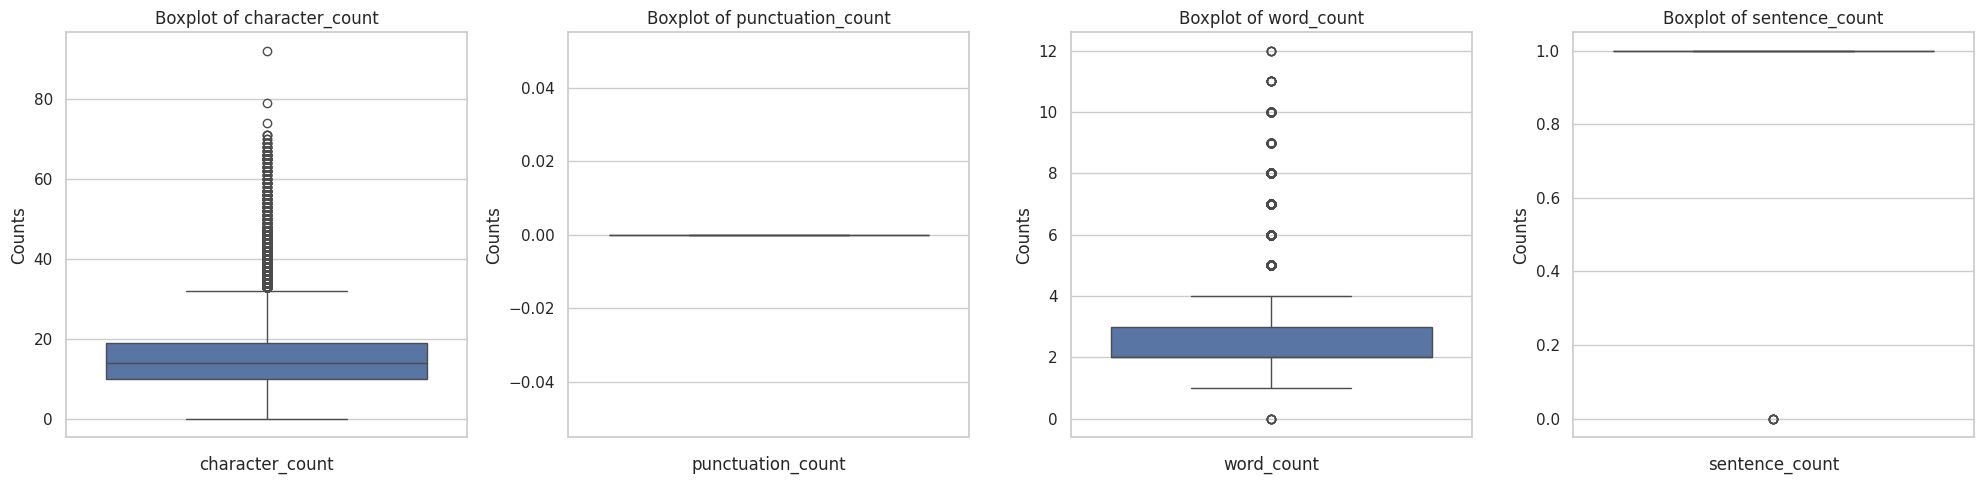

In [ ]:
show_boxplots(train_df_features)

### Validation queries

In [ ]:
queries_validation.head(10)

,qid,query
0,2230207,2017 welsh local elections
1,105188,chinese poetry
2,465829,crawford productions
3,584743,prix du jockey club
4,1693050,dennis joseph
5,145020,vigo
6,86153,mikhail lermontov
7,1014887,royal mail steam packet company
8,207982,katerini
9,1325,byzantium


In [ ]:
validation_df_features = counter_feature(queries_validation, 'query')

In [ ]:
validation_df_features.head(10)

,character_count,punctuation_count,word_count,sentence_count
0,26,0,4,1
1,14,0,2,1
2,20,0,2,1
3,19,0,4,1
4,13,0,2,1
5,4,0,1,1
6,17,0,2,1
7,31,0,5,1
8,8,0,1,1
9,9,0,1,1


In [ ]:
validation_df_features.describe()

,character_count,punctuation_count,word_count,sentence_count
count,1000.000000,1000.0,1000.000000,1000.0
mean,15.528000,0.0,2.283000,1.0
std,8.301574,0.0,1.192616,0.0
min,1.000000,0.0,1.000000,1.0
25%,10.000000,0.0,2.000000,1.0
50%,14.000000,0.0,2.000000,1.0
75%,19.000000,0.0,3.000000,1.0
max,57.000000,0.0,9.000000,1.0


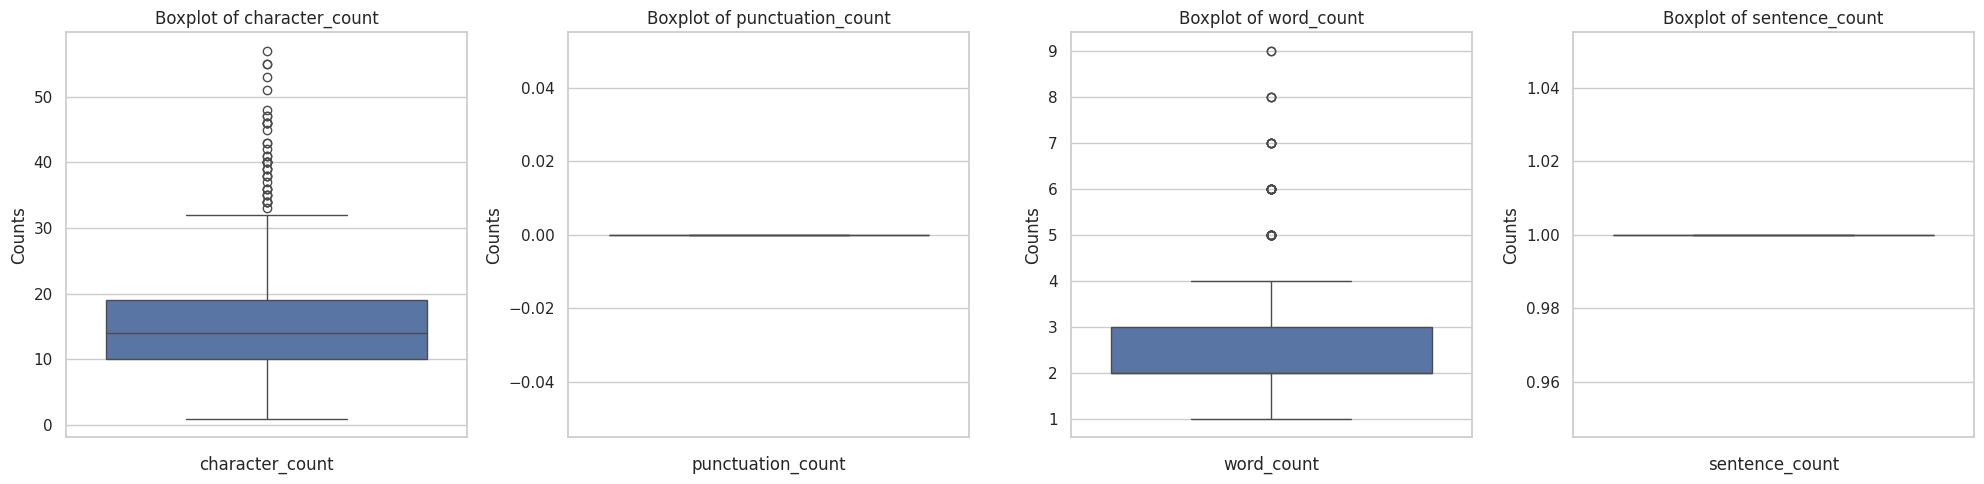

In [ ]:
show_boxplots(validation_df_features)

### Test queries

In [ ]:
queries_test.head(10)

,qid,query
0,1981012,canadian folklore
1,1164242,viral disease
2,851225,city of rockingham
3,229027,andrei konchalovsky
4,171884,jagex
5,844031,ian proctor
6,25170,environmental science
7,76925,vilvoorde
8,30595,electric generator
9,271014,sentinel range


In [ ]:
test_df_features = counter_feature(queries_test, 'query')

In [ ]:
test_df_features.head(10)

,character_count,punctuation_count,word_count,sentence_count
0,17,0,2,1
1,13,0,2,1
2,18,0,3,1
3,19,0,2,1
4,5,0,1,1
5,11,0,2,1
6,21,0,2,1
7,9,0,1,1
8,18,0,2,1
9,14,0,2,1


In [ ]:
test_df_features.describe()

,character_count,punctuation_count,word_count,sentence_count
count,1000.000000,1000.0,1000.000000,1000.0
mean,15.194000,0.0,2.229000,1.0
std,8.194603,0.0,1.187421,0.0
min,3.000000,0.0,1.000000,1.0
25%,10.000000,0.0,1.000000,1.0
50%,13.500000,0.0,2.000000,1.0
75%,18.000000,0.0,3.000000,1.0
max,65.000000,0.0,10.000000,1.0


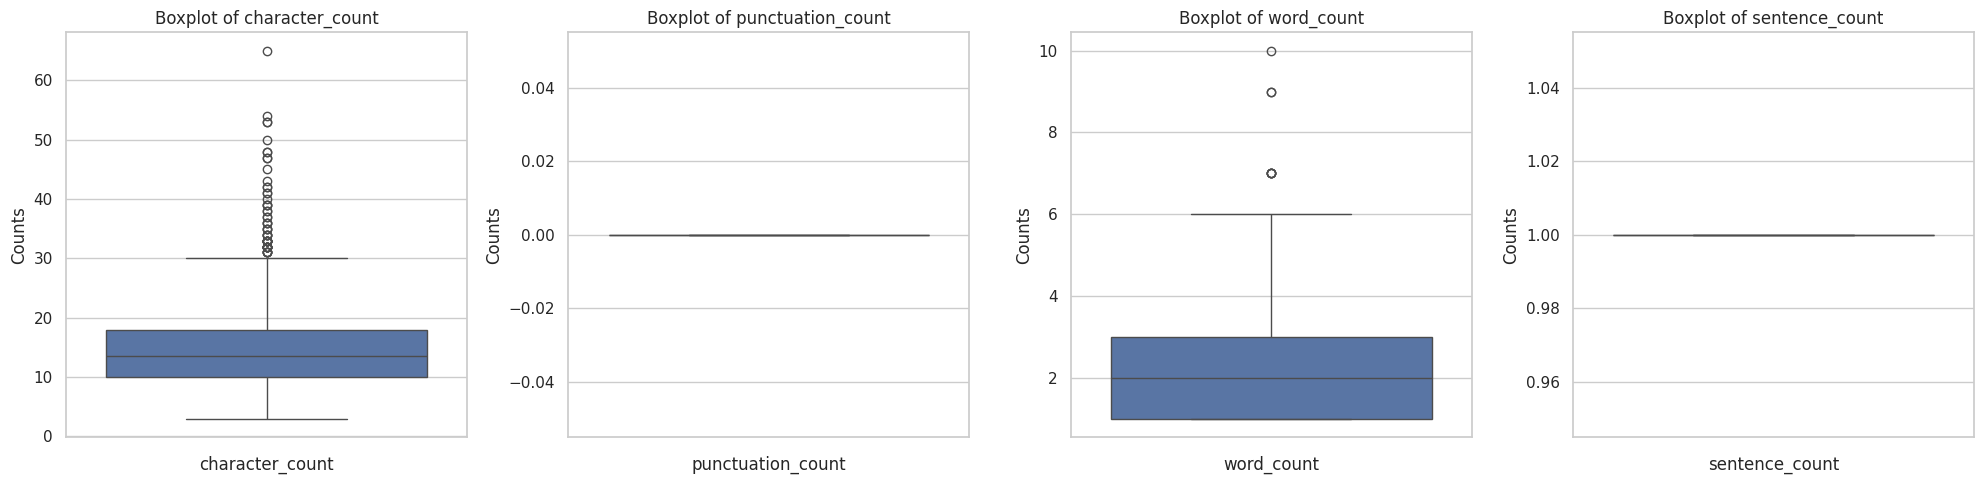

In [ ]:
show_boxplots(test_df_features)

## Indexing

### Base index

In [ ]:
import os
index_path = base_path + "/indicies_v2/wikir59_index/index_base"
if not os.path.exists(index_path + "/data.properties"):
    indexer = pt.index.IterDictIndexer(index_path, stopwords=None, stemmer=None, meta={"docno": 221})

    filtered_corpus = (doc for doc in dataset_train.get_corpus_iter() if doc['text'] is not None)

    index_ref = indexer.index(filtered_corpus,
                              fields=['text'])

else:
    index_ref = pt.IndexRef.of(index_path + "/data.properties")

index_base = pt.IndexFactory.of(index_ref)

print(f"Index statistics:\n{index_base.getCollectionStatistics().toString()}")

wikir/en59k/training documents:   0%|          | 0/2454785 s<?, ?it/s]

Index statistics:
Number of documents: 2454785
Number of terms: 2279653
Number of postings: 289341657
Number of fields: 1
Number of tokens: 485247923
Field names: [text]
Positions:   false



### No stop words

In [ ]:
index_path = base_path + "/indicies_v2/wikir59_index/index_nostopwords"
if not os.path.exists(index_path + "/data.properties"):
    indexer = pt.index.IterDictIndexer(index_path, stemmer=None, meta={"docno": 221})

    filtered_corpus = (doc for doc in dataset_train.get_corpus_iter() if doc['text'] is not None)

    index_ref = indexer.index(filtered_corpus,
                              fields=['text'])

else:
    index_ref = pt.IndexRef.of(index_path + "/data.properties")

index_nostopwords = pt.IndexFactory.of(index_ref)

print(f"Index statistics:\n{index_nostopwords.getCollectionStatistics().toString()}")

wikir/en59k/training documents:   0%|          | 0/2454785 s<?, ?it/s]

Index statistics:
Number of documents: 2454785
Number of terms: 2279058
Number of postings: 211208941
Number of fields: 1
Number of tokens: 274289077
Field names: [text]
Positions:   false



### Stemming

In [ ]:
index_path = base_path + "/indicies_v2/wikir59_index/index_stemming"
if not os.path.exists(index_path + "/data.properties"):
    indexer = pt.index.IterDictIndexer(index_path, stopwords=None, meta={"docno": 221})

    filtered_corpus = (doc for doc in dataset_train.get_corpus_iter() if doc['text'] is not None)

    index_ref = indexer.index(filtered_corpus,
                              fields=['text'])

else:
    index_ref = pt.IndexRef.of(index_path + "/data.properties")

index_stemming = pt.IndexFactory.of(index_ref)

print(f"Index statistics:\n{index_stemming.getCollectionStatistics().toString()}")

wikir/en59k/training documents:   0%|          | 0/2454785 s<?, ?it/s]

Index statistics:
Number of documents: 2454785
Number of terms: 1986693
Number of postings: 279522019
Number of fields: 1
Number of tokens: 485247923
Field names: [text]
Positions:   false



### No stop words + stemming

In [ ]:
index_path = base_path + "/indicies_v2/wikir59_index/index_nostopwords_stamming"
if not os.path.exists(index_path + "/data.properties"):
    indexer = pt.index.IterDictIndexer(index_path, meta={"docno": 221})

    filtered_corpus = (doc for doc in dataset_train.get_corpus_iter() if doc['text'] is not None)

    index_ref = indexer.index(filtered_corpus,
                              fields=['text'])

else:
    index_ref = pt.IndexRef.of(index_path + "/data.properties")

index_nostopwords_stamming = pt.IndexFactory.of(index_ref)

print(f"Index statistics:\n{index_nostopwords_stamming.getCollectionStatistics().toString()}")

wikir/en59k/training documents:   0%|          | 0/2454785 s<?, ?it/s]

Index statistics:
Number of documents: 2454785
Number of terms: 1986533
Number of postings: 202906209
Number of fields: 1
Number of tokens: 274289077
Field names: [text]
Positions:   false



### Import indexes

In [ ]:
indexes ={
    "index_base": pt.IndexFactory.of(dataset_path + 'indicies_v2/wikir59_index/index_base/data.properties'),
    "index_nostopwords": pt.IndexFactory.of(dataset_path + 'indicies_v2/wikir59_index/index_nostopwords/data.properties'),
    "index_nostopwords_stemming": pt.IndexFactory.of(dataset_path + 'indicies_v2/wikir59_index/index_nostopwords_stamming/data.properties'),
    "index_stemming": pt.IndexFactory.of(dataset_path + 'indicies_v2/wikir59_index/index_stemming/data.properties')
}

## Wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
def wordcloud(index):
  terms = []
  frequencies = []

  for term, le in index.getLexicon():
      terms.append(term)
      frequencies.append(le.getFrequency())

  word_freq = {term: freq for term, freq in zip(terms, frequencies)}

  wordcloud = WordCloud(width=1600, height=800, background_color ='white').generate_from_frequencies(word_freq)

  plt.figure(figsize=(20,14))
  plt.imshow(wordcloud, interpolation='antialiased')
  plt.axis('off')
  plt.show()

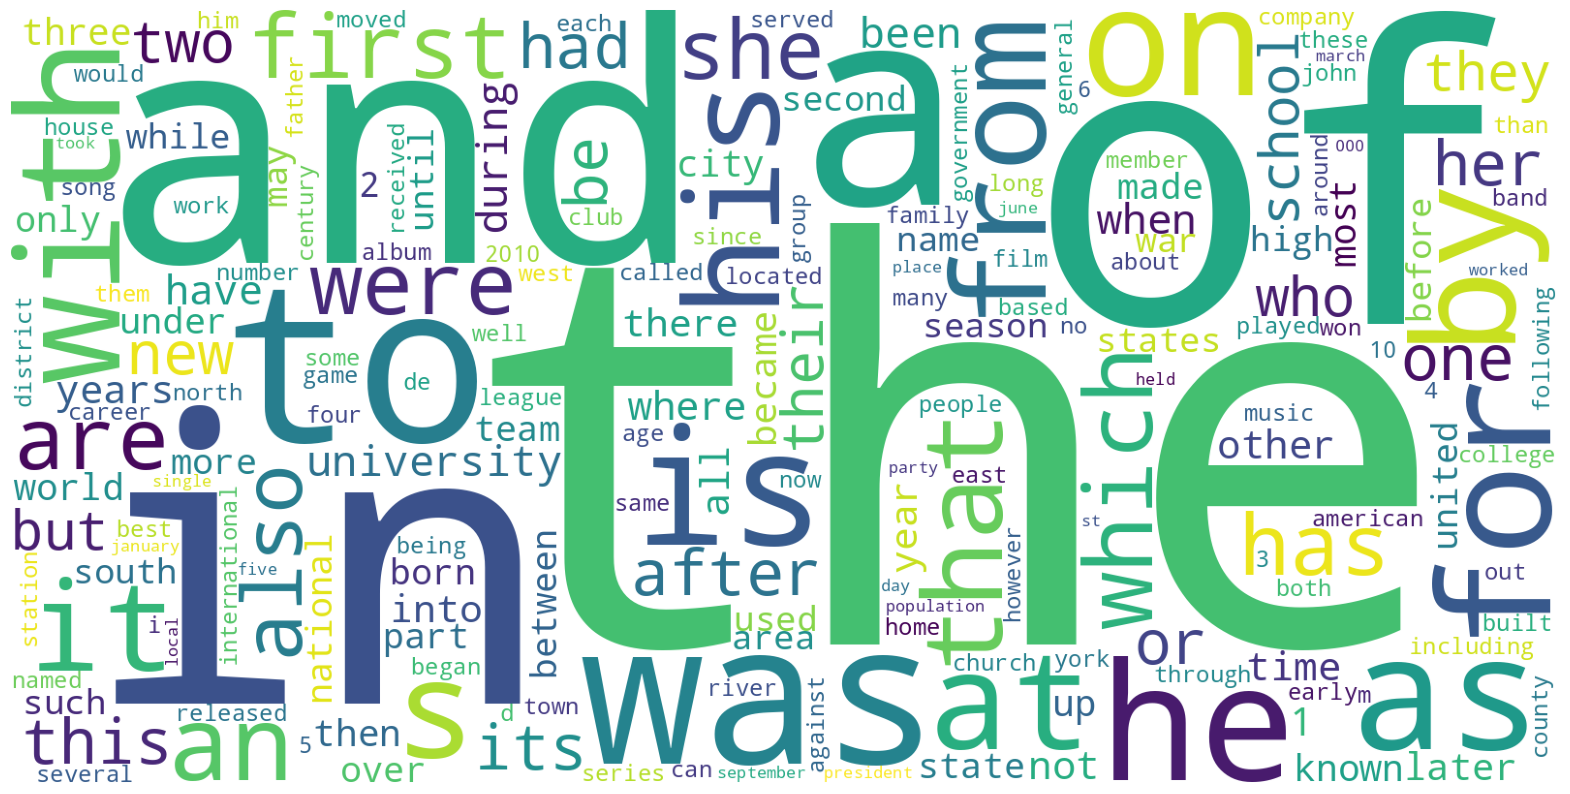

In [ ]:
wordcloud(indexes["index_base"])

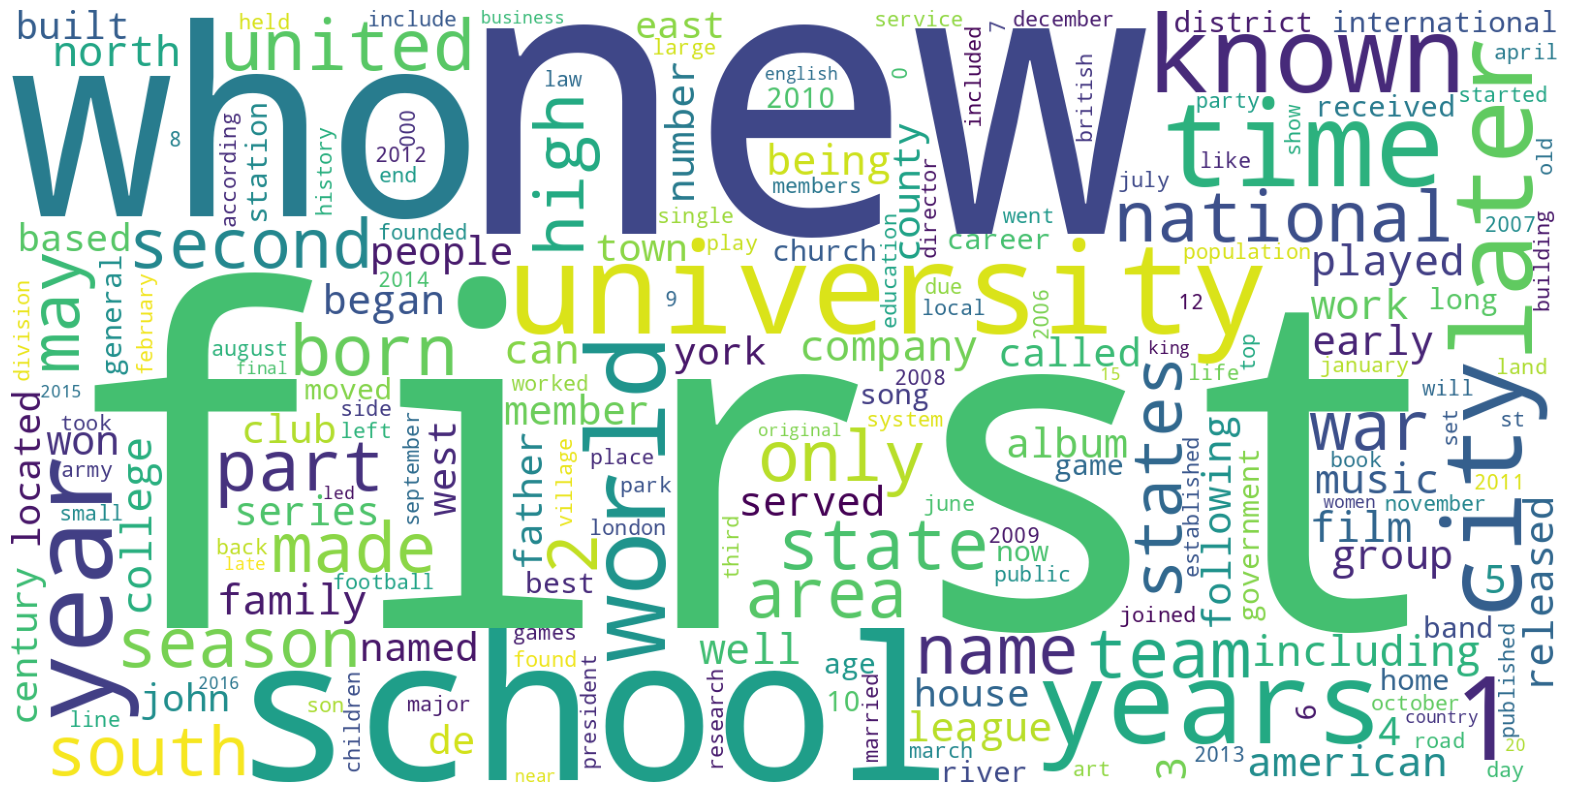

In [ ]:
wordcloud(indexes["index_nostopwords"])

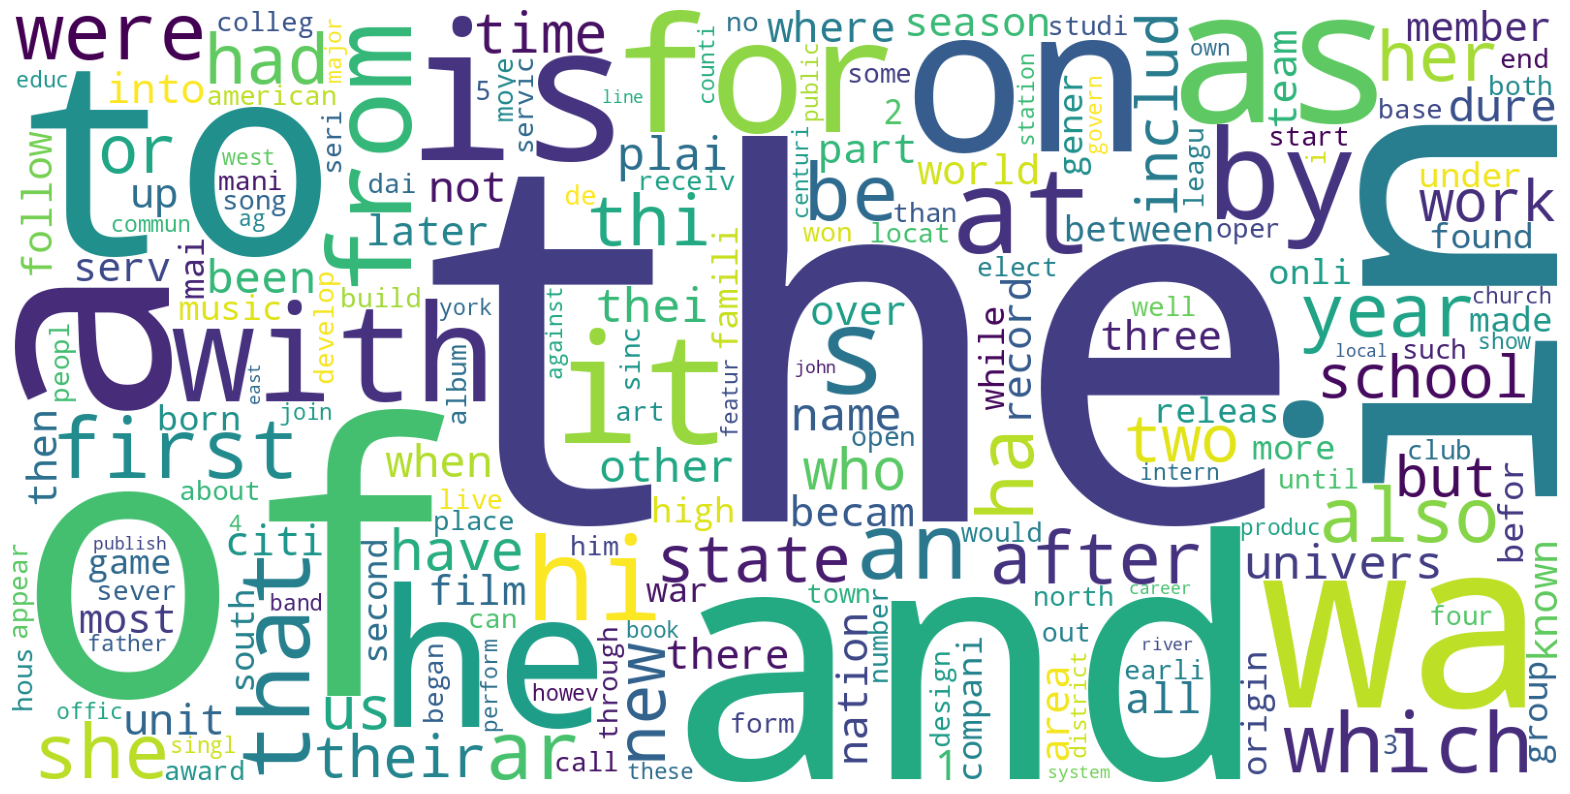

In [ ]:
wordcloud(indexes["index_stemming"])

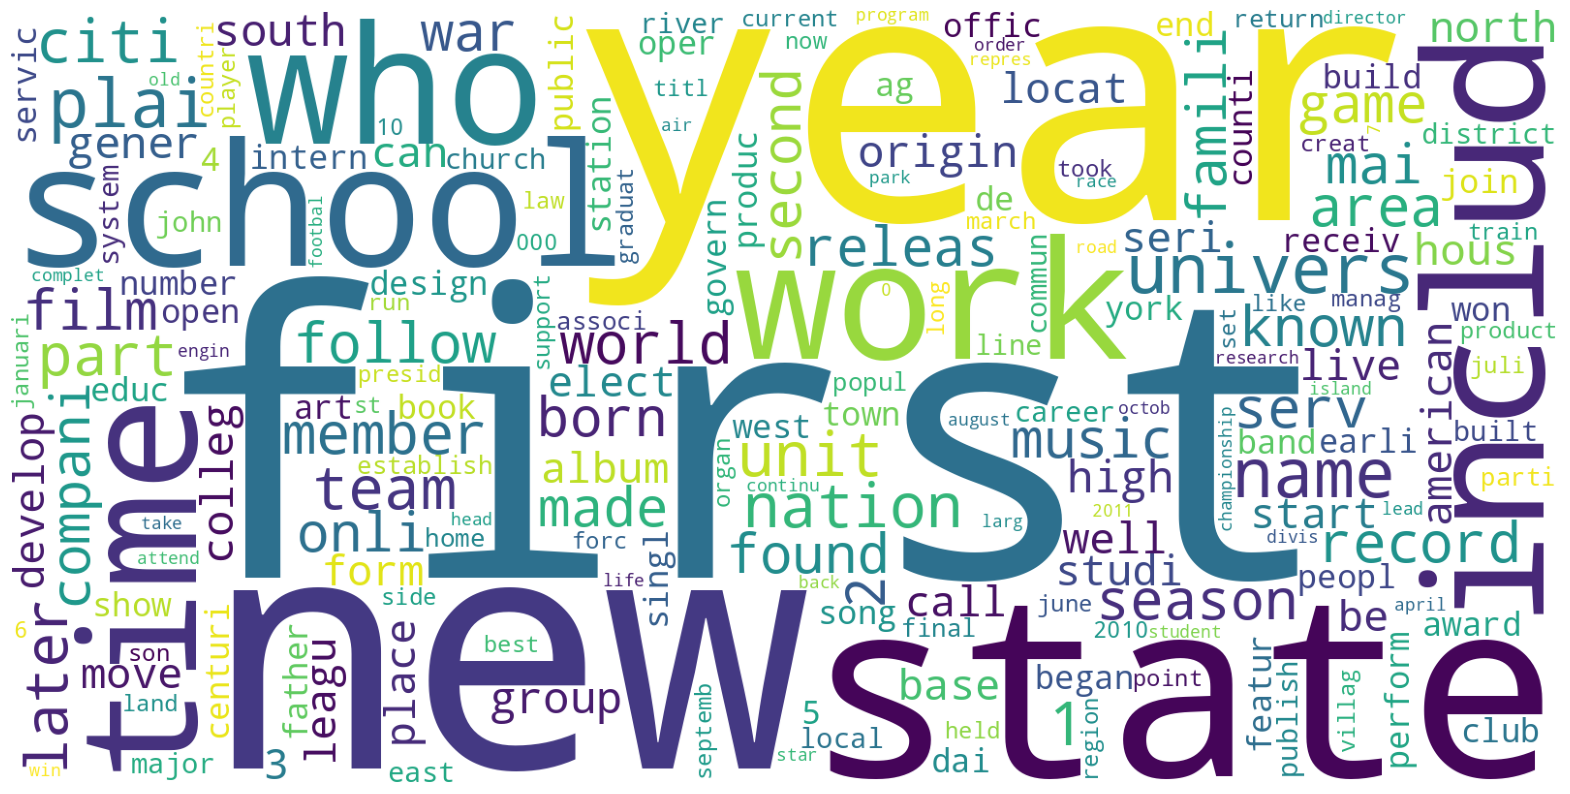

In [ ]:
wordcloud(indexes["index_nostopwords_stemming"])

## Models

### TF-IDF

In [ ]:
import os
import pickle

In [ ]:
models = {}

In [ ]:
for index in indexes:
  new_index = f"tfidf_{index}"
  model_path = dataset_path + 'models/' + new_index + '.pkl'

  os.makedirs(os.path.dirname(model_path), exist_ok=True)

  if os.path.exists(model_path):
      with open(model_path, 'rb') as file:
          best_model = pickle.load(file)

      print(f"Loaded model from {model_path}")
      models[new_index] = best_model
  else:
    tfidf = pt.BatchRetrieve(indexes[index], num_result=1000, wmodel="TF_IDF")
    models[new_index] = tfidf

    with open(model_path, 'wb') as file:
        pickle.dump(tfidf, file)
    print(f"Model saved to {model_path}")

Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/tfidf_index_base.pkl
Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/tfidf_index_nostopwords.pkl
Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/tfidf_index_nostopwords_stemming.pkl
Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/tfidf_index_stemming.pkl


### BM25

In [ ]:
for index in indexes:
  new_index = f"bm25_{index}"
  model_path = dataset_path + 'models/' + new_index + '.pkl'

  os.makedirs(os.path.dirname(model_path), exist_ok=True)

  if os.path.exists(model_path):
    with open(model_path, 'rb') as file:
        best_model = pickle.load(file)

    print(f"Loaded model from {model_path}")
    models[new_index] = best_model
  else:
    BM25 = pt.BatchRetrieve(indexes[index], wmodel="BM25", controls={"bm25.b" : 0.75, "bm25.k_1": 0.75})

    pt.GridSearch(BM25,
      {BM25: {"bm25.b"  : [0, 0.2, 0.4, 0.6, 0.8, 1],
              "bm25.k_1": [1.2, 1.4, 1.6, 2]
      }}, queries_validation, qrels_validation, "map")

    models[new_index] = BM25

    with open(model_path, 'wb') as file:
        pickle.dump(BM25, file)
    print(f"Model saved to {model_path}")

Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/bm25_index_base.pkl
Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/bm25_index_nostopwords.pkl
Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/bm25_index_nostopwords_stemming.pkl
Loaded model from /content/drive/My Drive/IR_project/wikIR59k/models/bm25_index_stemming.pkl


### Evaluation

In [ ]:
from pyterrier.measures import *

In [ ]:
models_eval_metrics_results = pt.Experiment(
    list(models.values()),
    queries_test,
    qrels_test,
    eval_metrics=[P@5, P@10, P@20, R@5, R@10, R@20, MAP, RR, nDCG],
    names=list(models.keys())
)
display(models_eval_metrics_results)

,name,P@5,P@10,P@20,R@5,R@10,R@20,AP,RR,nDCG
0,tfidf_index_base,0.2488,0.1956,0.14950,0.108355,0.161526,0.228017,0.148532,0.538485,0.376933
1,tfidf_index_nostopwords,0.2512,0.1953,0.15050,0.108703,0.162451,0.229251,0.149490,0.538905,0.377292
2,tfidf_index_nostopwords_stemming,0.2480,0.1934,0.14965,0.106809,0.159796,0.226721,0.146528,0.535613,0.376902
3,tfidf_index_stemming,0.2450,0.1935,0.14935,0.105922,0.158792,0.227152,0.145800,0.539659,0.377248
4,bm25_index_base,0.2404,0.1882,0.14550,0.105016,0.155349,0.221225,0.142348,0.512554,0.364868
5,bm25_index_nostopwords,0.2530,0.1963,0.15005,0.109009,0.163275,0.229286,0.149013,0.537765,0.376658
6,bm25_index_nostopwords_stemming,0.2462,0.1937,0.14955,0.105753,0.159797,0.226564,0.146044,0.535272,0.376828
7,bm25_index_stemming,0.2330,0.1853,0.14370,0.101003,0.152443,0.219189,0.138665,0.510669,0.363182


## Models + Query Expantion


In [ ]:
model_path = '/content/drive/MyDrive/IR_project/wikIR59k/models/bm25_index_nostopwords.pkl'

with open(model_path, 'rb') as file:
  bm25_best_model = pickle.load(file)

### BM25 + RM3

In [29]:
def bm25_qe_generator_RM3(index, bm25_best_model):
  qe_model_path = dataset_path + 'models/bm25_qe_rm3.pkl'

  rm3 = pt.rewrite.RM3(indexes[index], fb_terms=10, fb_docs=3)
  bm25_pipe_qe = bm25_best_model >> rm3 >> bm25_best_model

  param_map = {
          rm3 : {
              "fb_terms" : list(range(1, 12, 3)),
              "fb_docs" : list(range(2, 30, 6))
          }
  }
  bm25_pipe_qe = pt.GridSearch(bm25_pipe_qe,
                              param_map,
                              queries_validation,
                              qrels_validation)

  with open(qe_model_path, 'wb') as file:
    pickle.dump(bm25_pipe_qe, file)
  print(f"Model saved to {qe_model_path}")

In [30]:
bm25_qe_generator_RM3('index_nostopwords', bm25_best_model)

Best map is 0.156284
Best setting is ['QueryExpansion(/content/drive/My Drive/IR_project/wikIR59k/indicies_v2/wikir59_index/index_nostopwords/data.properties,26,10,<org.terrier.querying.RM3 at 0x7d2e2e3b12b0 jclass=org/terrier/querying/RM3 jself=<LocalRef obj=0x58cc97df0d38 at 0x7d2dd5759d90>>) fb_terms=10', 'QueryExpansion(/content/drive/My Drive/IR_project/wikIR59k/indicies_v2/wikir59_index/index_nostopwords/data.properties,26,10,<org.terrier.querying.RM3 at 0x7d2e2e3b12b0 jclass=org/terrier/querying/RM3 jself=<LocalRef obj=0x58cc97df0d38 at 0x7d2dd5759d90>>) fb_docs=8']
Model saved to /content/drive/My Drive/IR_project/wikIR59k/models/bm25_qe_rm3.pkl


### BM25 + Bo1

In [ ]:
def bm25_qe_generator_BO1(index, bm25_best_model):
    qe_model_path = dataset_path + 'models/bm25_qe_bo1.pkl'

    bo1 = pt.rewrite.Bo1QueryExpansion(indexes[index], fb_terms=10, fb_docs=3)
    bm25_pipe_qe = bm25_best_model >> bo1 >> bm25_best_model

    param_map = {
        bo1: {
            "fb_terms": list(range(1, 12, 3)),
            "fb_docs": list(range(2, 30, 6))
        }
    }

    bm25_pipe_qe = pt.GridSearch(bm25_pipe_qe,
                                 param_map,
                                 queries_validation,
                                 qrels_validation)

    with open(qe_model_path, 'wb') as file:
        pickle.dump(bm25_pipe_qe, file)
    print(f"Model saved to {qe_model_path}")

In [ ]:
bm25_qe_generator_BO1('index_nostopwords', bm25_best_model)

### Evaluation


In [31]:
model_path_RM3 = '/content/drive/MyDrive/IR_project/wikIR59k/models/bm25_qe_rm3.pkl'
with open(model_path, 'rb') as file:
  bm25_qe_rm3 = pickle.load(file)

In [32]:
model_path = '/content/drive/MyDrive/IR_project/wikIR59k/models/bm25_qe_bo1.pkl'
with open(model_path, 'rb') as file:
  bm25_qe_bo1 = pickle.load(file)

In [33]:
models_qe = {"Best BM25": bm25_best_model,
             "BM25 + RM3": bm25_qe_rm3,
             "BM25 + Bo1": bm25_qe_bo1}

In [34]:
bm25_qe_eval_metrics_results = pt.Experiment(
    list(models_qe.values()),
    queries_test,
    qrels_test,
    eval_metrics=[P@5, P@10, P@20, R@5, R@10, R@20, MAP, RR, nDCG],
    names=list(models_qe.keys())
    )
display(bm25_qe_eval_metrics_results)

,name,P@5,P@10,P@20,R@5,R@10,R@20,AP,RR,nDCG
0,Best BM25,0.2530,0.1963,0.15005,0.109009,0.163275,0.229286,0.149013,0.537765,0.376658
1,BM25 + RM3,0.2596,0.2061,0.15730,0.112020,0.170302,0.241911,0.162526,0.522427,0.397469
2,BM25 + Bo1,0.2596,0.2061,0.15730,0.112020,0.170302,0.241911,0.162526,0.522427,0.397469


## Rerank with BERT

In [ ]:
import pickle
model_path = '/content/drive/MyDrive/IR_project/wikIR59k/models/bm25_qe.pkl'
with open(model_path, 'rb') as file:
  bm25_model = pickle.load(file)

In [ ]:
vbert = onir_pt.reranker.from_checkpoint('https://macavaney.us/scibert-medmarco.tar.gz', text_field='text')
pipeline_re_rank_BERT = bm25_model % 100 >> pt.text.get_text(dataset_train, 'text') >> pt.apply.generic(lambda df: df.dropna()) >> vbert

config file not found: config


[2024-06-20 20:21:28,654][onir.util.download][WARNING] no hash provided for https://macavaney.us/scibert-medmarco.tar.gz; consider adding expected_md5="854966d0b61543ffffa44cea627ab63b" to ensure data integrity.
[2024-06-20 20:21:28,659][onir.util.download][DEBUG] downloaded https://macavaney.us/scibert-medmarco.tar.gz [3.73s] [499M] [138MB/s]


[2024-06-20 20:21:55,559][onir.util.download][DEBUG] downloaded https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/pytorch_models/scibert_scivocab_uncased.tar [23.15s] [411M] [23.8MB/s] [md5 hash verified]


extracting: 411MB [2.76s, 149MB/s]
extracting: 821MB [6.56s, 125MB/s]


In [ ]:
#Run the evaluation
from pyterrier.measures import *
results = pt.Experiment(
    [bm25_model, pipeline_re_rank_BERT],
    queries_test,
    qrels_test,
    eval_metrics=[P@5, P@10, P@20, R@5, R@10, R@20, MAP, RR, nDCG],
    names=['BM25', 'BM25 >> VBERT'],
    baseline=0
)

#Show the results
display(results)

In [ ]:
import pandas as pd

# Export the DataFrame to a CSV file
results.to_csv('/content/drive/MyDrive/IR_project/bert_qe_rm3_results.csv', index=False)